In [90]:
import json
import mysql.connector
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
from datetime import datetime
import re
import os
import io
import base64
import matplotlib.pyplot as plt


mysql_conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="",
    database="cedur",
    charset="utf8mb4",     # wichtig für Emojis
    use_unicode=True       # stellt sicher, dass Python Unicode-Strings nutzt
)

cursor = mysql_conn.cursor(dictionary=True)
engine = create_engine("mysql+mysqlconnector://root:@localhost/cedur")


usergroup_str = "usergroup > 0"

if 1 == 1: 

    base_user = {}

    base_user['summary'] = {}
    query = "SELECT COUNT(DISTINCT fcid) AS cnt FROM `forms_10010` WHERE " + usergroup_str
    cursor.execute(query)
    row = cursor.fetchone()
    count = row['cnt']
    base_user['summary']['visits'] = count

    query = "SELECT COUNT(DISTINCT fcid) AS cnt FROM `forms_10003` WHERE " + usergroup_str
    cursor.execute(query)
    row = cursor.fetchone()
    count = row['cnt']
    base_user['summary']['patients'] = count

    query = "SELECT fcont, COUNT(*) cnt FROM `forms_10003` WHERE fid=96 AND " + usergroup_str +  " GROUP BY fcont"
    cursor.execute(query)
    rows = cursor.fetchall()
    base_user['gender'] = {}
    for row in rows:
        base_user['gender'][row['fcont']] = row['cnt']

    query ="SELECT fcont, COUNT(*) cnt FROM `forms_10003` WHERE fid=95 AND " + usergroup_str +  " GROUP BY fcont"    
    cursor.execute(query)
    rows = cursor.fetchall()
    base_user['diagnosis'] = {}
    for row in rows:
        base_user['diagnosis'][row['fcont']] = row['cnt']

    print(json.dumps(base_user, indent=2, ensure_ascii=False))



{
  "summary": {
    "visits": 33632,
    "patients": 3883
  },
  "gender": {
    "männlich": 1832,
    "weiblich": 2051
  },
  "diagnosis": {
    "": 25,
    "Colitis indeterminata": 48,
    "Colitis ulcerosa": 1825,
    "Morbus Crohn": 1985
  }
}


In [ ]:
def rename_df(df_temp, fdef_a):
    renaming_map = {}
    for column_name in df_temp.columns:
        if column_name in fdef_a:
            renaming_map[column_name] = fdef_a[column_name]
    df_renamed = df_temp.rename(columns=renaming_map)
    return df_renamed

def get_missing_value_fcids(df_temp, mask):
    df_temp = df.reset_index() # macht fcid zu einer normalen Spalte
    return df_temp.loc[mask, "fcid"].tolist()

def get_fid_def(cursor):
    fdef_a = {}
    query = """SELECT * FROM forms_definition WHERE 
    (fg=10003 OR fg=10005 OR fg=10010 OR fg=10020) 
    AND ftype NOT LIKE '%info%'
    AND ftype NOT LIKE '%start_fieldset%'
    AND ftype NOT LIKE '%logicblock_100%'
    """
    cursor.execute(query)
    rows = cursor.fetchall()
    for row in rows:
        fdef_a[row['fid']] = row['fname']
    for fid, fname in fdef_a.items():
        clean_name = fname
        clean_name = re.sub(r"</?[^>]+>", "", clean_name)
        clean_name = re.sub(r"\[.*?\]", "", clean_name)   
        clean_name = (
            clean_name
            .replace('@10@', '')
            .replace('@30@', '')
            .replace('➥', '')
            .replace('@ONETIME@', '')
            .replace('CEDUR3.Allgemein.', '')
            .replace('|Bitte wählen', '')#
            .replace('|Bitte Einheit angeben', '')
            .replace('|Automatikfeld', '')
            .replace('`', '')
            .replace('(Bei Stoma: Beutelentleerungen) hatten Sie in der vergangenen Woche durchschnittlich pro Tag?', '')
            .replace('(Wenn Sie nicht wissen, was das ist, haben bzw. hatten Sie auch keine)', '')    
            .strip()
        )
        clean_name = clean_name.replace('Datum der Erstdiagnose','Erstdiagnose')
        clean_name = clean_name.replace('Erste Symptome Ihrer Erkrankung?','Erstsymptomatik')
        clean_name = clean_name.replace('Benennen Sie bitte die Lokalisation (Colitis ulcerosa)','Lokalisation CU')
        
        clean_name = clean_name.split('|')
        fdef_a[fid] = clean_name[0]
    return fdef_a
 
def get_patients():
    query = "SELECT fcid, fid, fcont FROM `forms_10003` WHERE fid in (92, 97,95,96,10003020) AND " + usergroup_str
    df_src = pd.read_sql(query, engine)
    df_temp_pivot = df_src.pivot(index="fcid", columns="fid", values="fcont")
    df_temp_pivot.columns.name = 'id'
    df_temp_pivot = df_temp_pivot.reset_index()
    df_final = rename_df(df_temp_pivot, fdef_a)
    df_final = df_final.rename(columns={'fcid': 'pid'})
    return df_final

def get_helper_loc_mc_cu():
    query = "SELECT fcid, fid, fcont FROM `forms_10010` WHERE fid IN (90,102000,101902,101904,101906,101908,101910) AND fcont<>'';"
    df_crc_temp = pd.read_sql(query, engine)    
    df_temp_pivot = df_crc_temp.pivot(index="fcid", columns="fid", values="fcont")
    df_temp_pivot.columns.name = 'id'
    df_temp_pivot = df_temp_pivot.reset_index()
    df_temp = rename_df(df_temp_pivot, fdef_a)

    ####### MC ######### 
    # mc checkboxex to single text field
    lokal_cols = ["Nur terminales Ileum", "Nur Colon", "Ileo-Colon", "Oberer GI-Trakt (Öspohagus u./o. Magen u./o. Duodenum)", "Dünndarmbefall (Jejunum / Ileum (außer term. Ileum)"]
    df_temp["Lokalisation MC"] = df_temp[lokal_cols].apply(
        lambda row: ",".join([col for col in lokal_cols if str(row[col]) == "1"]),
        axis=1
    )
    # df_temp["Lokalisation MC"].value_counts()
    conditions = {
        "Ileo-Colon": "L3", 
        "Nur terminales Ileum": "L1", 
        "Nur Colon": "L2", 
        "Ileo-Colon,Oberer GI-Trakt (Öspohagus u./o. Magen u./o. Duodenum)": "L3/L4", 
        "Ileo-Colon,Dünndarmbefall (Jejunum / Ileum (außer term. Ileum)": "L3/L4", 
        "Nur terminales Ileum,Dünndarmbefall (Jejunum / Ileum (außer term. Ileum)": "L1/L4", 
        "Nur Colon,Oberer GI-Trakt (Öspohagus u./o. Magen u./o. Duodenum)": "L2/L4", 
        "Dünndarmbefall (Jejunum / Ileum (außer term. Ileum)": "L4", 
        "Oberer GI-Trakt (Öspohagus u./o. Magen u./o. Duodenum)": "L4", 
        "Nur terminales Ileum,Ileo-Colon": "L3", 
        "Nur Colon,Ileo-Colon": "X1", 
        "Oberer GI-Trakt (Öspohagus u./o. Magen u./o. Duodenum),Dünndarmbefall (Jejunum / Ileum (außer term. Ileum)": "L4", 
        "Ileo-Colon,Oberer GI-Trakt (Öspohagus u./o. Magen u./o. Duodenum),Dünndarmbefall (Jejunum / Ileum (außer term. Ileum)": "X2"
    } 
    df_temp["Montreal MC"] = df_temp["Lokalisation MC"].map(conditions)
    # print(df_temp["Lokalisation MC"].value_counts())
    df_temp_MC = df_temp[["fcid","pid","Montreal MC"]]
    df_temp_MC.loc[df_temp_MC['Montreal MC'] == '', 'Montreal MC'] = pd.NA  # Delete Empty
    df_temp_MC = df_temp_MC.dropna(subset=['Montreal MC'])                  # Delete Empty
    df_temp_MC['pid'] = pd.to_numeric(df_temp_MC['pid'], errors='coerce')
    df_temp_MC = df_temp_MC.sort_values(by="fcid")
    df_temp_MC_unique = df_temp_MC.drop_duplicates(subset="pid", keep='last')

    ####### CU #########     
    conditions = {
        "Pancolitis": "E3",
        "Linksseiten Colitis": "E2",
        "Proktitis": "E1"
    }
    df_temp["Montreal CU"] = df_temp["Lokalisation CU"].map(conditions)
    df_temp_CU = df_temp[["fcid","pid","Montreal CU"]]
    df_temp_CU.loc[df_temp_CU['Montreal CU'] == '', 'Montreal CU'] = pd.NA  # Delete Empty
    df_temp_CU = df_temp_CU.dropna(subset=['Montreal CU'])                  # Delete Empty
    df_temp_CU['pid'] = pd.to_numeric(df_temp_CU['pid'], errors='coerce')
    df_temp_CU = df_temp_CU.sort_values(by="fcid")
    df_temp_CU_unique = df_temp_CU.drop_duplicates(subset="pid", keep='last')
    # print(df_temp_CU_unique["Montreal CU"].value_counts())
    # Ceck: SELECT count(*) FROM CEDUR3_allgemein WHERE Montreal_Lokalisation_CU='Linksseiten Colitis' GROUP BY pid
    return df_temp_MC_unique, df_temp_CU_unique

def get_field_one_of_some(fid, value, remain_type, col_name = ''):
    query = "SELECT fcid, fid, fcont FROM `forms_10010` WHERE fid IN (90, " + str(fid) + ") ;"
    # print(query)
    df_src = pd.read_sql(query, engine, dtype={"fcont": str})
    df_src["fcont"] = df_src["fcont"].astype(str)
    df_pivot = df_src.pivot(index="fcid", columns="fid", values="fcont")
    df_pivot.loc[df_pivot[fid] == '', fid] = pd.NA  # Delete Empty
    df_pivot = df_pivot.dropna(subset=[fid])        # Delete Empty
    df_print = df_pivot
    df_print.to_csv("test.csv", sep=";", index=False) 
    l_src = df_pivot.shape[0]
    if value:
        df_pivot = df_pivot[df_pivot[fid] == value]
    df_pivot.columns.name = 'id'
    df_pivot = df_pivot.reset_index()
    df_pivot = rename_df(df_pivot, fdef_a)
    if col_name != '':
        df_pivot = df_pivot.rename(columns={fdef_a[fid]: col_name})
    df_pivot['pid'] = pd.to_numeric(df_pivot['pid'], errors='coerce')
    df_pivot = df_pivot.sort_values(by="fcid")
    df_pivot_unique = df_pivot.drop_duplicates(subset="pid", keep=remain_type)
    l_unique = df_pivot_unique.shape[0]
    print(f"{col_name}")
    print(df_print[fid].describe())
    print(f"{fid}): {l_src} => {l_unique}")
    print(df_pivot_unique.describe())
    return df_pivot_unique

def col_to_numeric(df_temp, field):
    df_temp[field] = pd.to_numeric(
        df_temp[field].astype(str).str.replace(",", "."),
        errors="coerce"
    )
    # df_temp[field] = df_temp[field].map(lambda x: f"{x:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")) # Tausender Punkt
    return df_temp

def get_medication():
    query = "SELECT fcid, fid, fcont FROM `forms_10020` WHERE fid in (90, 10020020, 10020040, 10020050, 10020080) AND " + usergroup_str + " ORDER BY fcid"
    df_src = pd.read_sql(query, engine)
    df_temp_pivot = df_src.pivot(index="fcid", columns="fid", values="fcont")
    df_temp_pivot.columns.name = 'id'
    df_temp_pivot = df_temp_pivot.reset_index()
    df_final = rename_df(df_temp_pivot, fdef_a)
    return df_final

In [92]:
# Create patient-df

fdef_a = get_fid_def(cursor)
# print(list(fdef_a.items())[:5])

df_p = get_patients()
df_p_MC, df_p_CU = get_helper_loc_mc_cu()

df_merged = df_p
df_merged = df_merged.merge(df_p_MC, on="pid", how="left")
df_merged = df_merged.drop('fcid', axis=1)
df_merged = df_merged.merge(df_p_CU, on="pid", how="left")
df_merged = df_merged.drop('fcid', axis=1)
df_p = df_merged

df_a = {}
i = 0;
i += 1; df_a[i] = get_field_one_of_some(102200, '','first', 'Erstdiagnose')
i += 1; df_a[i] = get_field_one_of_some(102300, '','first', 'Erstsymptomatik')  
i += 1; df_a[i] = get_field_one_of_some(102700, '','first', 'Gewicht bei Einschluss') 
i += 1; df_a[i] = get_field_one_of_some(102700, '','last', 'Gewicht zuletzt')
i += 1; df_a[i] = get_field_one_of_some(102800, '','first', 'Rauchen bei Einschluss') 
i += 1; df_a[i] = get_field_one_of_some(102800, '','last', 'Rauchen zuletzt')
i += 1; df_a[i] = get_field_one_of_some(106700, '','last', 'Schulabschluss') 
i += 1; df_a[i] = get_field_one_of_some(106000, '','last', 'Taetigkeit') 
i += 1; df_a[i] = get_field_one_of_some(106600, '','last', 'Umfang Taetigkeit') 
i += 1; df_a[i] = get_field_one_of_some(106200, '','last', 'CED-Krankschreibung') # jemals im erlauf
i += 1; df_a[i] = get_field_one_of_some(105000, '','last', 'Verwandte erkrankt') # jemals im erlauf
i += 1; df_a[i] = get_field_one_of_some(102500, '','last', 'Krankenhaustage') # jemals im erlauf
i += 1; df_a[i] = get_field_one_of_some(106900, '','first', 'Operationen') # jemals im erlauf
i += 1; df_a[i] = get_field_one_of_some(102000, '','last', 'Loc CU') # jemals im erlauf
i += 1; df_a[i] = get_field_one_of_some(101902, '','last', 'Loc MC (Nur terminales Ileum)') # jemals im erlauf
i += 1; df_a[i] = get_field_one_of_some(101904, '','last', 'Loc MC (Nur Colon)') # jemals im erlauf
i += 1; df_a[i] = get_field_one_of_some(101906, '','last', 'Loc MC (Ileo-Colon)') # jemals im erlauf
i += 1; df_a[i] = get_field_one_of_some(101908, '','last', 'Loc MC (Oberer GI-Trakt)') # jemals im erlauf
i += 1; df_a[i] = get_field_one_of_some(101910, '','last', 'Loc MC (Dünndarmbefall)') # jemals im erlauf


df_merged = df_p
for index in df_a:
    df_merged = df_merged.merge(df_a[index], on="pid", how="left")
    df_merged = df_merged.drop('fcid', axis=1)
df_p = df_merged.reset_index()

df_p.loc[:, 'Erstdiagnose'] = df_p['Erstdiagnose'].str[-4:]
df_p.loc[:, 'Erstsymptomatik'] = df_p['Erstsymptomatik'].str[-4:]

print(df_p.shape)
# print(df_p['Diagnose'].value_counts())
# print(df_p["Montreal MC"].value_counts())
# print(df_p["Montreal CU"].value_counts())

Erstdiagnose
count     28245
unique      309
top        2010
freq       1293
Name: 102200, dtype: object
102200): 28245 => 3561
id             fcid           pid
count  3.561000e+03  3.561000e+03
mean   2.019450e+15  2.018865e+15
std    3.695066e+12  4.205442e+12
min    2.013062e+15  2.013011e+15
25%    2.015121e+15  2.014092e+15
50%    2.020011e+15  2.019113e+15
75%    2.023042e+15  2.023021e+15
max    2.025092e+15  2.025092e+15
Erstsymptomatik
count     28072
unique      242
top        2009
freq       1307
Name: 102300, dtype: object
102300): 28072 => 3545
id             fcid           pid
count  3.545000e+03  3.545000e+03
mean   2.019462e+15  2.018870e+15
std    3.701204e+12  4.207381e+12
min    2.013062e+15  2.013011e+15
25%    2.015121e+15  2.014092e+15
50%    2.020012e+15  2.019113e+15
75%    2.023043e+15  2.023021e+15
max    2.025092e+15  2.025092e+15
Gewicht bei Einschluss
count     33309
unique      456
top          70
freq       1189
Name: 102700, dtype: object
102700): 33309

In [96]:

df_p = col_to_numeric(df_p, "Erstdiagnose")
df_p = col_to_numeric(df_p, "Erstsymptomatik")
df_p = col_to_numeric(df_p, "Geburtsjahr")


mask = (df_p['Erstdiagnose'] > 0) & (df_p['Erstsymptomatik'] > 0) &  (df_p['Erstdiagnose'] >= df_p['Erstsymptomatik'])
df_p['Zeit bis Diagnose'] = df_p[mask]['Erstdiagnose'] -  df_p[mask]['Erstsymptomatik']
# df_p['Zeit bis Diagnose'] = (df_p['Erstdiagnose'] - df_p['Erstsymptomatik']).where(mask)
# df_p.loc[mask, 'Zeit bis Diagnose'] = df_p.loc[mask, 'Erstdiagnose'] - df_p.loc[mask, 'Erstsymptomatik']
print(df_p['Zeit bis Diagnose'].describe())

jahr = datetime.now().year
mask = (df_p['Geburtsjahr'] > 0) 
df_p['Altersprofil'] = jahr - df_p[mask]['Geburtsjahr']

mask = (df_p['Erstdiagnose'] > 0) & (df_p['Geburtsjahr'] > 0) 
df_p['Alter bei Diagnose'] = df_p[mask]['Erstdiagnose'] - df_p[mask]['Geburtsjahr']

df_p = df_p.rename(columns={"groesse": "Groesse"})

print(df_p)

df_p = col_to_numeric(df_p, "Gewicht bei Einschluss")
df_p = col_to_numeric(df_p, "Gewicht zuletzt")
df_p = col_to_numeric(df_p, "Groesse")


if 1 == 0:
    df_temp = df_p
    tmp_mask = ~(df_temp["Groesse"].isna() | (df_temp["Groesse"] == ""))
    df_clean = df_temp[tmp_mask]
    print(df_temp.shape[0], "=>", df_clean.shape[0])
    df_p = df_temp

    df_temp = df_p
    tmp_mask = ~(df_temp["Diagnose"].isna() | (df_temp["Diagnose"] == ""))
    df_clean = df_temp[tmp_mask]
    print(df_temp.shape[0], "=>", df_clean.shape[0])
    df_p = df_temp

    df_temp = df_p
    tmp_mask = ~(df_temp["Erstdiagnose"].isna() | (df_temp["Erstdiagnose"] == ""))
    df_clean = df_temp[tmp_mask]
    print(df_temp.shape[0], "=>", df_clean.shape[0])
    df_p = df_temp

    df_temp = df_p
    tmp_mask = ~(df_temp["Erstsymptomatik"].isna() | (df_temp["Erstsymptomatik"] == ""))
    df_clean = df_temp[tmp_mask]
    print(df_temp.shape[0], "=>", df_clean.shape[0])
    df_p = df_temp



count    3531.000000
mean        1.636080
std         3.492013
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max        35.000000
Name: Zeit bis Diagnose, dtype: float64
id    index               pid   Cedur-Nr.          Diagnose geschlecht  \
0         0  2013010715082300  G630315255  Colitis ulcerosa   weiblich   
1         1  2013040209423100  G630387311      Morbus Crohn   weiblich   
2         2  2013060620351600  G630387546      Morbus Crohn   weiblich   
3         3  2013061909133200  G429903771      Morbus Crohn   weiblich   
4         4  2013061910182900  G429935226      Morbus Crohn   männlich   
...     ...               ...         ...               ...        ...   
3878   3878  2025091511141545    SVY-0194  Colitis ulcerosa   männlich   
3879   3879  2025091609461607    TZJ-6499      Morbus Crohn   männlich   
3880   3880  2025091609484688    KWD-3099  Colitis ulcerosa   männlich   
3881   3881  2025091611575850    JQK-8107  Colitis u

In [97]:

# Mediction

df_med = get_medication()
mask = (df_med['Medikamenten-Gruppe']=='Biologika')
df_med_all = df_med[mask]

cnt = df_med_all['Medikament Bezeichnung'].value_counts()
new_index = cnt.index.str.extract(r"^(.*?\))", expand=False)
new_index = new_index.where(new_index.notna(), cnt.index)
cnt.index = new_index
s_grouped_med = cnt.groupby(cnt.index).sum().sort_values(ascending=False)


bracket_index = cnt.index.str.extract(r"\((.*?)\)", expand=False)
bracket_index = bracket_index.where(bracket_index.notna(), cnt.index)
cnt.index = bracket_index
s_grouped_biosimilar = cnt.groupby(cnt.index).sum().sort_values(ascending=False)
s_grouped_biosimilar.index = s_grouped_biosimilar.index.str.replace(r"[\(\)]", "", regex=True)

df_unique_med_last = df_med_all.drop_duplicates(subset="pid", keep="last")
cnt = df_unique_med_last['Medikament Bezeichnung'].value_counts()
new_index = cnt.index.str.extract(r"^(.*?\))", expand=False)
new_index = new_index.where(new_index.notna(), cnt.index)
cnt.index = new_index
s_grouped_med_pat = cnt.groupby(cnt.index).sum().sort_values(ascending=False)

bracket_index = cnt.index.str.extract(r"\((.*?)\)", expand=False)
bracket_index = bracket_index.where(bracket_index.notna(), cnt.index)
cnt.index = bracket_index
s_grouped_biosimilar_pat = cnt.groupby(cnt.index).sum().sort_values(ascending=False)
s_grouped_biosimilar_pat.index = s_grouped_biosimilar_pat.index.str.replace(r"[\(\)]", "", regex=True)


In [ ]:
# print(df_p['Alter bei Diagnose'].describe())

bins = [0, 10, 20, 30, 40, 50, 60, 70, float("inf")]  
labels = ["0-10", "11-20", "21-30", "31-40", "41-50", "51-60","61-70",">70"]

# bins = [0, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, float("inf")]  
# labels = ["0-10", "11-15", "16-20", "21-25", "26-30", "31-35", "36-40", "41-45", "46-50", "51-55", "56-60", "61-70","71-80", ">80"]

df_p["Alter bei Diagnose (g)"] = pd.cut(df_p["Alter bei Diagnose"], bins=bins, labels=labels, right=True, include_lowest=True)


# print(df_p['Alter bei Diagnose (g)'][df_p['Geschlecht'] == 'weiblich'].describe())
# print(df_p['Alter bei Diagnose (g)'][df_p['Geschlecht'] == 'männlich'].describe())

# df_p['Alter bei Diagnose (g)'].value_counts()

df_p = df_p.rename(columns={"geschlecht": "Geschlecht"})
mask = (df_p['Geschlecht'] == 'weiblich') & (df_p['Diagnose'] == 'Morbus Crohn')
weiblich = df_p['Alter bei Diagnose (g)'][mask].value_counts().reindex(labels, fill_value=0)

mask = (df_p['Geschlecht'] == 'weiblich') 
maennlich = df_p['Alter bei Diagnose (g)'][df_p['Geschlecht'] == 'männlich'].value_counts().reindex(labels, fill_value=0)
print(weiblich)
print(maennlich)



KeyError: 'Geschlecht'

In [ ]:
# fid = 102200
# query = "SELECT fcid, fid, fcont FROM `forms_10010` WHERE fid IN (90," + str(fid) + ") ;"
# df_src = pd.read_sql(query, engine)
# df_pivot = df_src.pivot(index="fcid", columns="fid", values="fcont")
# df_pivot.loc[df_pivot[fid] == '', fid] = pd.NA  # Delete Empty
# df_pivot = df_pivot.dropna(subset=[fid])        # Delete Empty
# df_pivot[df_pivot[90] == '2013040209423100']

In [ ]:
# CSV -Export


df_p.to_csv("patients.csv", sep=";", index=False, encoding="utf-8-sig") #, decimal=","  


def write_html_file(html_str, filename):
    try:
        with open(filename, 'a', encoding='utf-8') as datei:
            datei.write(html_str)
            print(f"HTML in '{filename}' written.")
    except Exception as e:
            print(f"Error in HTML-writing: {e}")

# datetime.today().strftime("%Y%m%d_") + 
filename = "CEDUR_MIQ.html"
try:
    os.remove(filename)
    print(f"Die Datei '{filename}' wurde erfolgreich gelöscht.")
except FileNotFoundError:
    print(f"Die Datei '{filename}' wurde nicht gefunden.")
except PermissionError:
    print(f"Keine Berechtigung, die Datei '{filename}' zu löschen.")
except OSError as e:
    print(f"Ein anderer Fehler ist beim Löschen der Datei aufgetreten: {e}")
# css_script = "<link rel='stylesheet' href='cedur.css'>"
css_script = "<style>.page-break { page-break-before: always; /* oder: page-break-after: always */} /* Grundlayout */ body { font-family: ' Segoe UI' , Roboto, sans-serif; background-color: #f3f3f3; color: #111827; margin: 0; padding: 1rem; } h1{ color: white; padding:1rem; background-color: rgb(5, 86, 157); border-radius: 0.4rem; font-size: 22px; margin-bottom:20px; } h2{ background-color: rgb(227, 227, 227); color: dimgray; padding-left:2rem; padding-top:0.5rem; padding-bottom:1rem; border-radius: 0.4rem; font-size: 18px; margin-top:-15px; margin-bottom:20px; } h3{ margin-top:-15px; background-color: white; color: dimgray; padding-left:2rem; padding-bottom:0.3rem; border-radius: 0.4rem; } h3:hover{ background-color: rgb(227, 227, 227);; color: rgb(38, 154, 231); cursor: pointer; } .block{ background-color: white; border-radius: 0.4rem; } .hidden { display: none; } .container{ width: 100%; background-color: #ffffff; box-shadow: 0 2px 4px rgba(0,0,0,0.05); border-radius: 0.4rem; padding:2px; /* display:none; */ margin-bottom:30px; margin-top:-15px } /* Tabellen */ table.dataframe { width: 100%; border-collapse: collapse; margin: 1rem 0; /* margin-top:-15px; */ background-color: #ffffff; box-shadow: 0 2px 4px rgba(0,0,0,0.05); border-radius: 0.4rem; font-size: 0.875rem; } table.dataframe thead { background-color: dimgray; color: #ffffff; font-weight: 600; } table.dataframe th, table.dataframe td { padding: 0.25rem 0.75rem; border-bottom: 1px solid #e5e7eb; } table.dataframe tbody tr:hover { background-color: #f3f4f6; color:dimgray; } /* Verschachtelte Tabellen und Bilder */ table.dataframe td table.dataframe { margin: 0; box-shadow: none; } table.dataframe td img { max-width: 100%; height: auto; display: block; margin: 0.5rem auto; border-radius: 0.4rem; box-shadow: 0 1px 4px rgba(0,0,0,0.08); } /* Zentrierung */ table.dataframe thead th { text-align: center; } table.dataframe td { /* text-align: center; */ } /* Responsive Darstellung */ @media (max-width: 200px) { table.dataframe, table.dataframe thead, table.dataframe tbody, table.dataframe th, table.dataframe td, table.dataframe tr { display: block; } table.dataframe td { text-align: left; padding: 0.5rem 0.75rem; position: relative; } table.dataframe td:before { content: attr(data-label); position: absolute; left: 0.5rem; top: 0.5rem; font-weight: bold; color: #6b7280; } } .desc{color: darkblue; padding-left:1rem; padding-right:1rem; font-size: 14px; font-weight: normal; margin-top: -30px; margin-bottom: 30px;line-height: 20px;}</style>" 
js_script = "<script>function toggleElement(id) { const el = document.getElementById(id); if (!el) return; if (el.classList.contains('hidden')) {el.classList.replace('hidden', 'container'); } else if (el.classList.contains('container')) {el.classList.replace('container', 'hidden');}}</script>"
write_html_file("<!DOCTYPE html>\n<head>\n\n\n" + css_script + "\n" + js_script + "</head><body>" , filename)






Die Datei 'CEDUR_MIQ.html' wurde nicht gefunden.
HTML in 'CEDUR_MIQ.html' written.


HTML in 'CEDUR_MIQ.html' written.


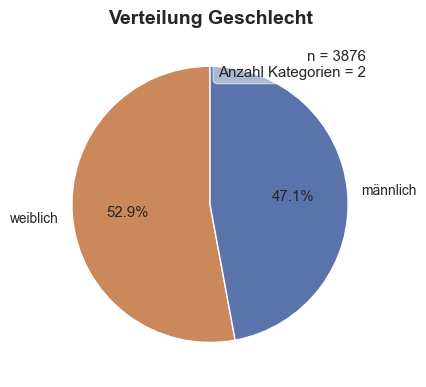

HTML in 'CEDUR_MIQ.html' written.


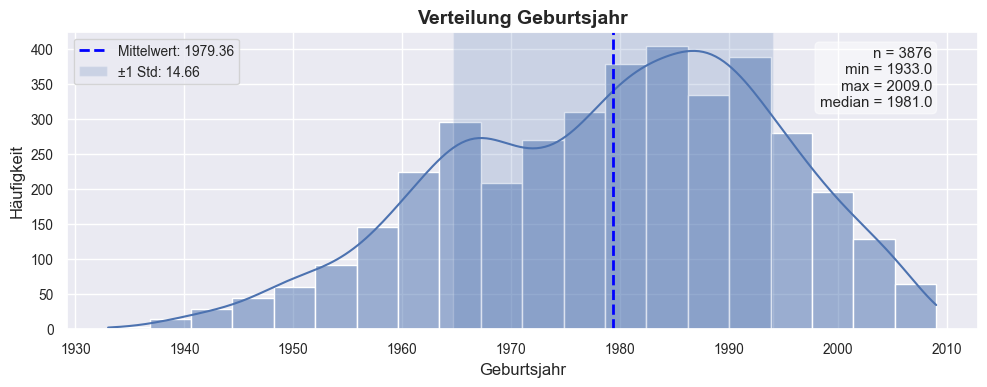

HTML in 'CEDUR_MIQ.html' written.


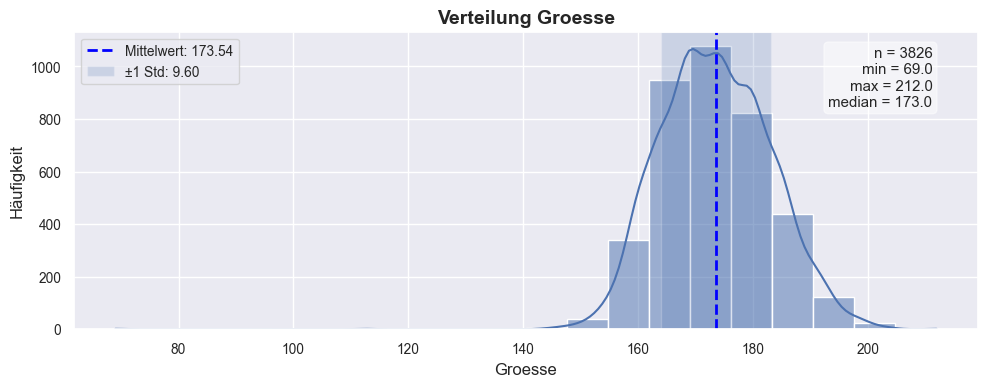

HTML in 'CEDUR_MIQ.html' written.


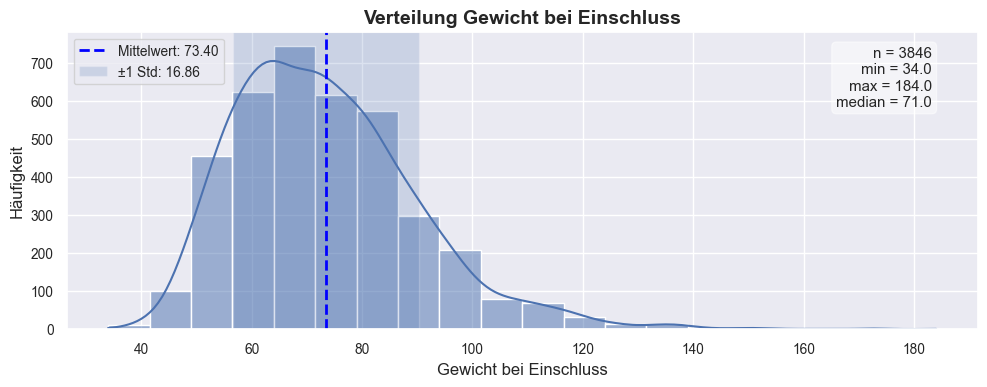

HTML in 'CEDUR_MIQ.html' written.


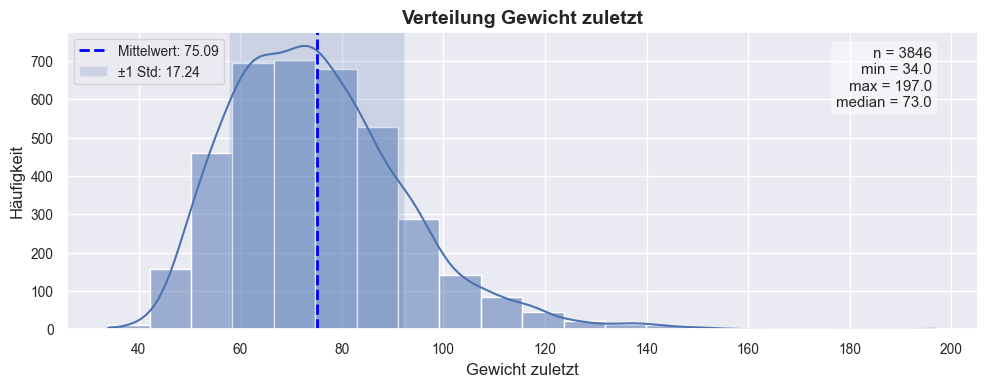

HTML in 'CEDUR_MIQ.html' written.


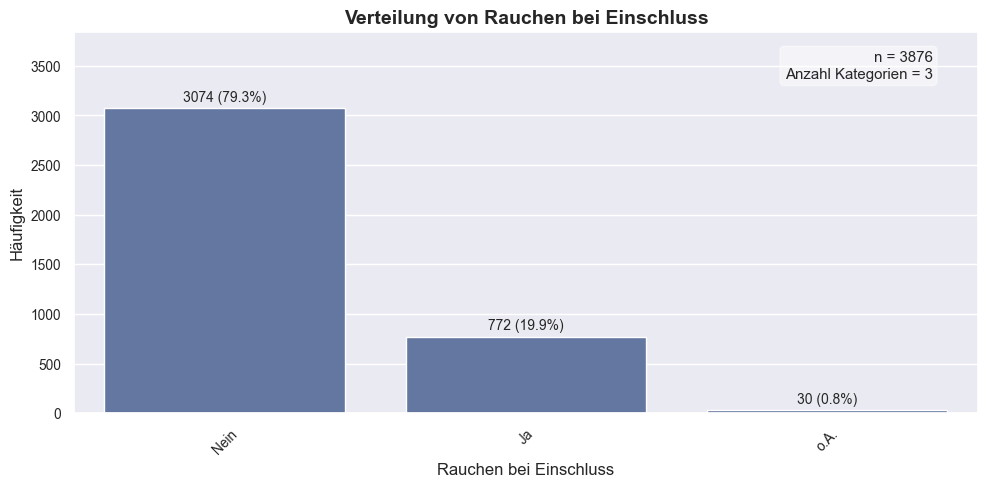

HTML in 'CEDUR_MIQ.html' written.


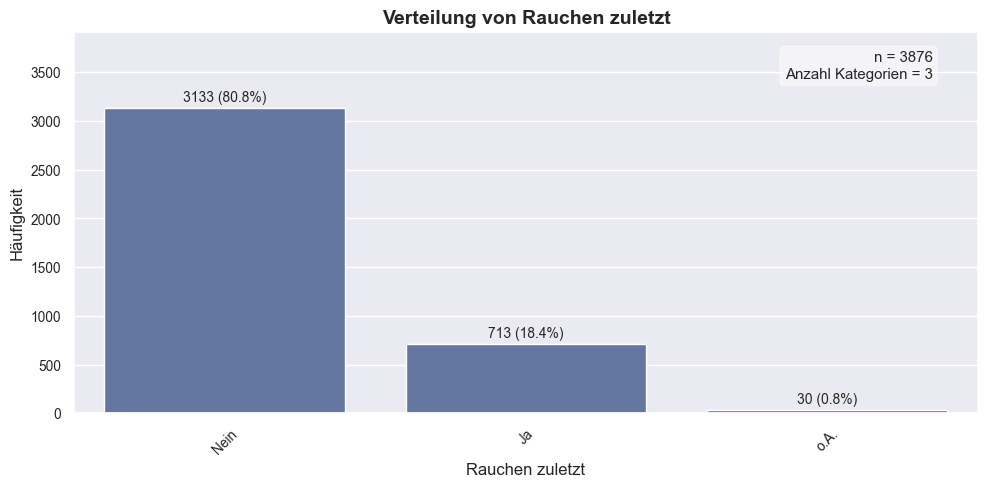

HTML in 'CEDUR_MIQ.html' written.
HTML in 'CEDUR_MIQ.html' written.


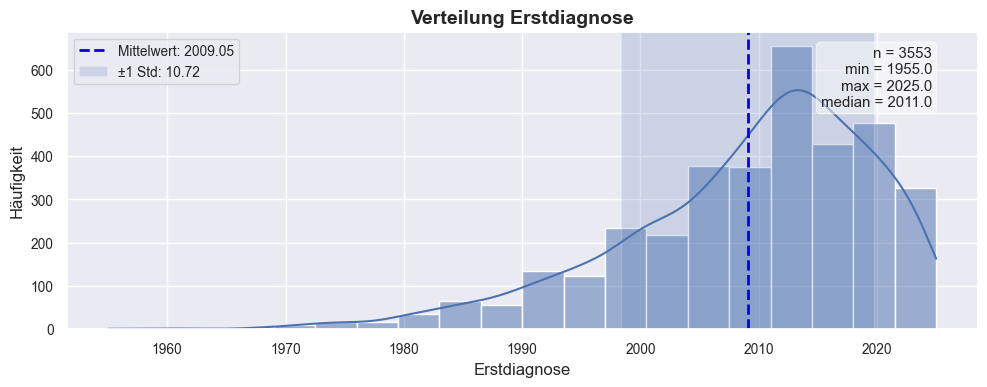

HTML in 'CEDUR_MIQ.html' written.


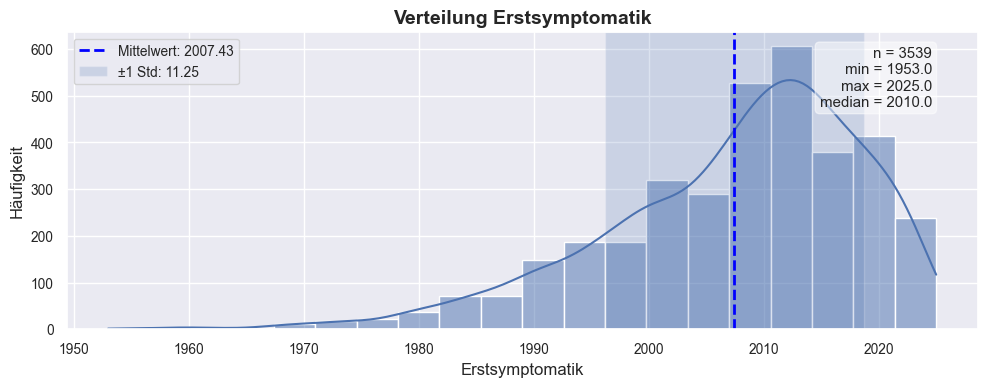

HTML in 'CEDUR_MIQ.html' written.


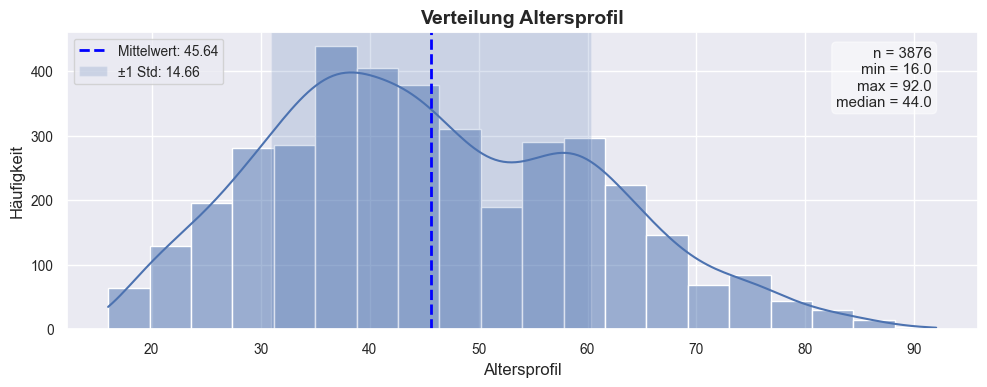

HTML in 'CEDUR_MIQ.html' written.


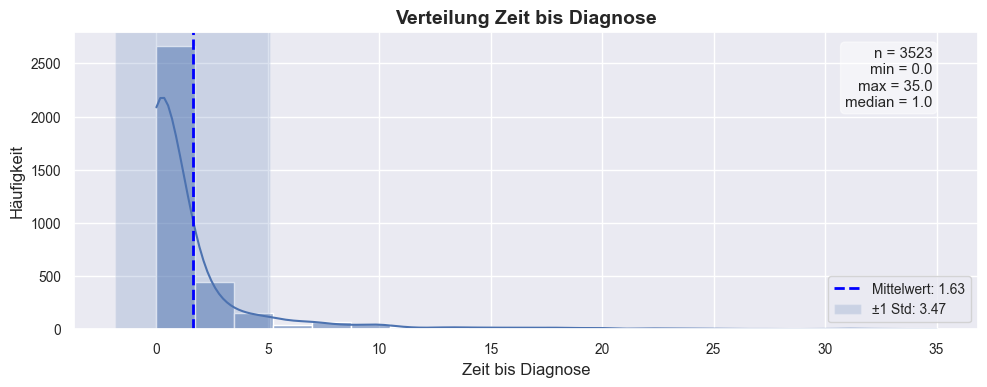

HTML in 'CEDUR_MIQ.html' written.


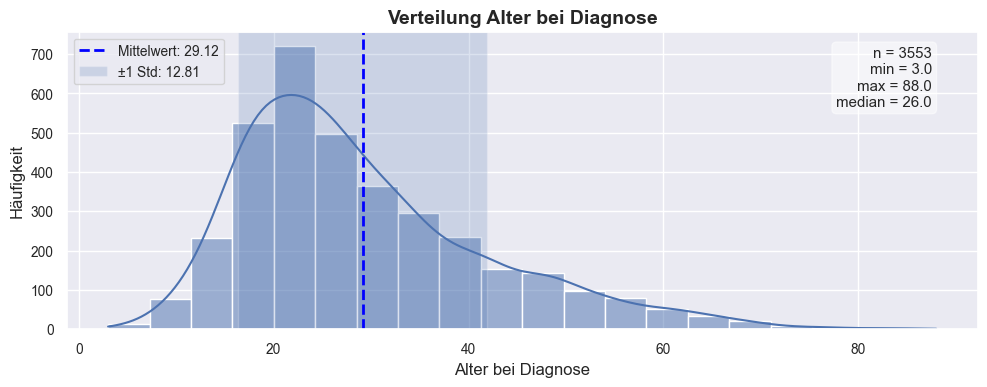

HTML in 'CEDUR_MIQ.html' written.


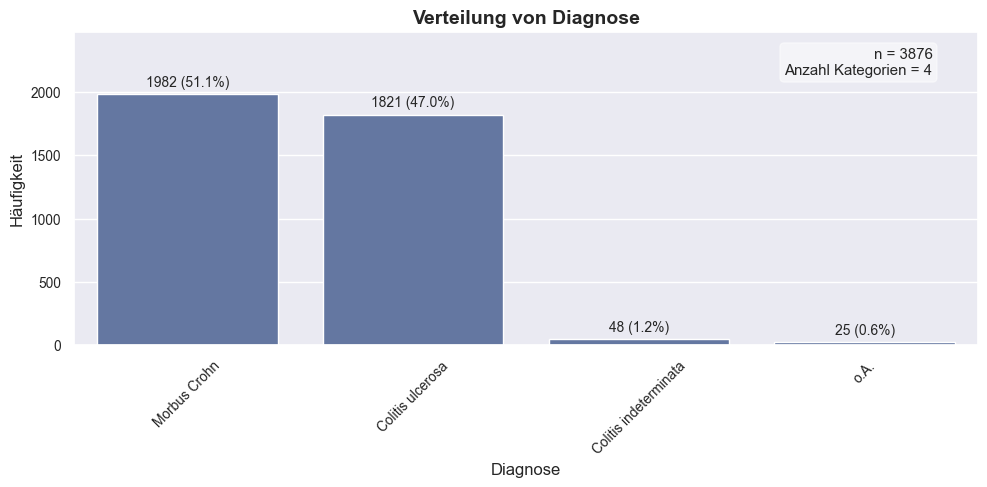

HTML in 'CEDUR_MIQ.html' written.


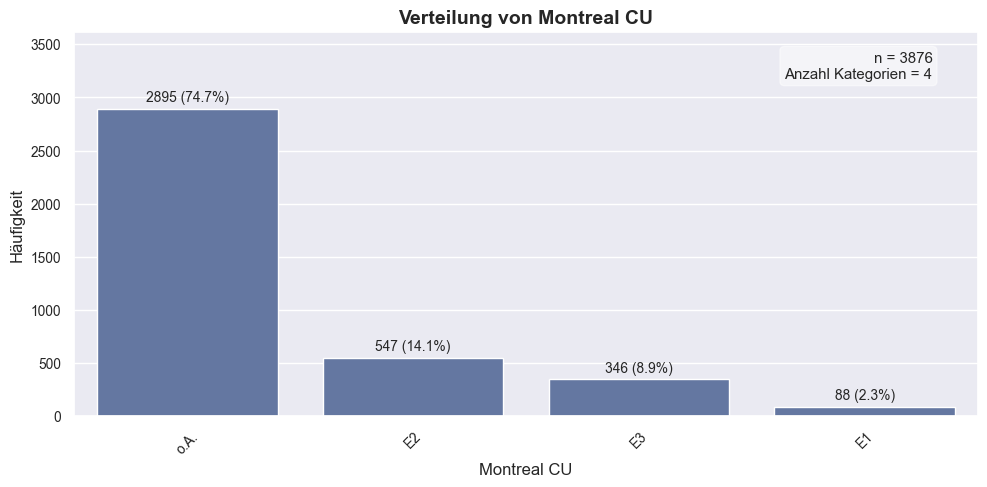

HTML in 'CEDUR_MIQ.html' written.


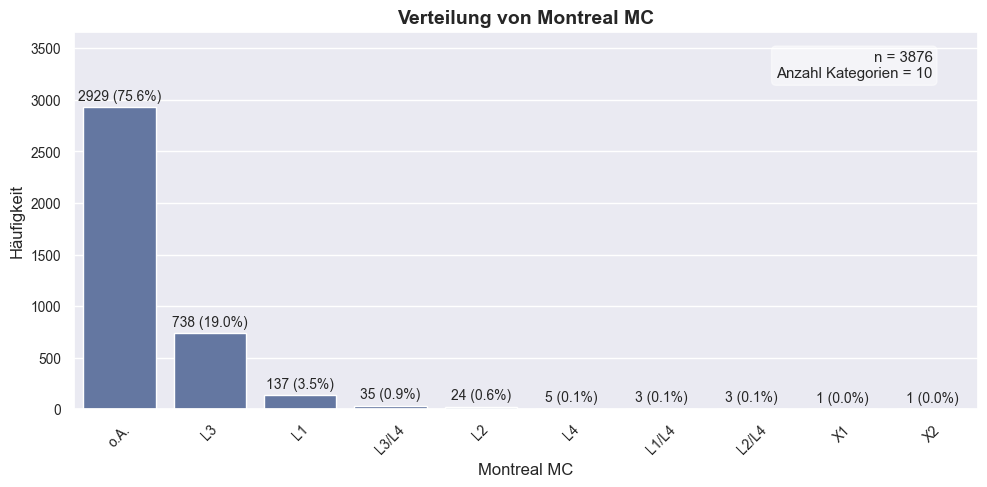

HTML in 'CEDUR_MIQ.html' written.
HTML in 'CEDUR_MIQ.html' written.


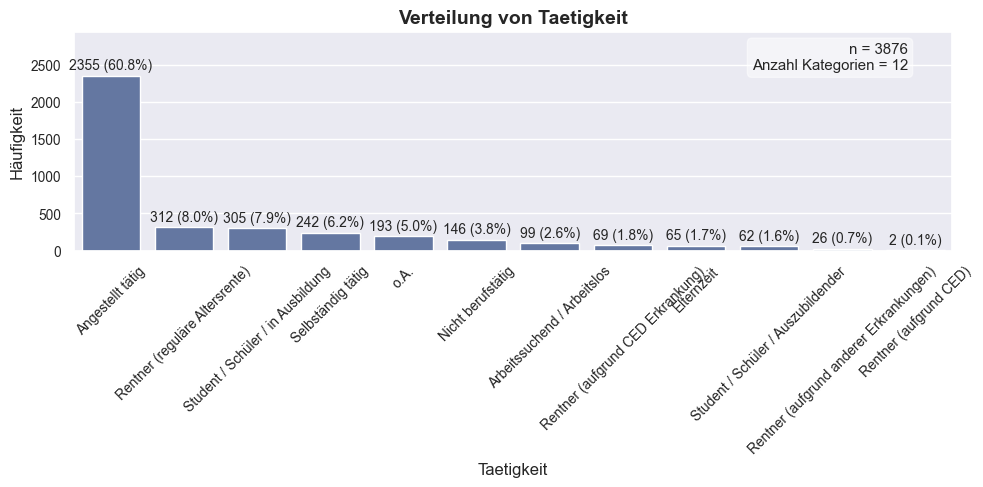

HTML in 'CEDUR_MIQ.html' written.


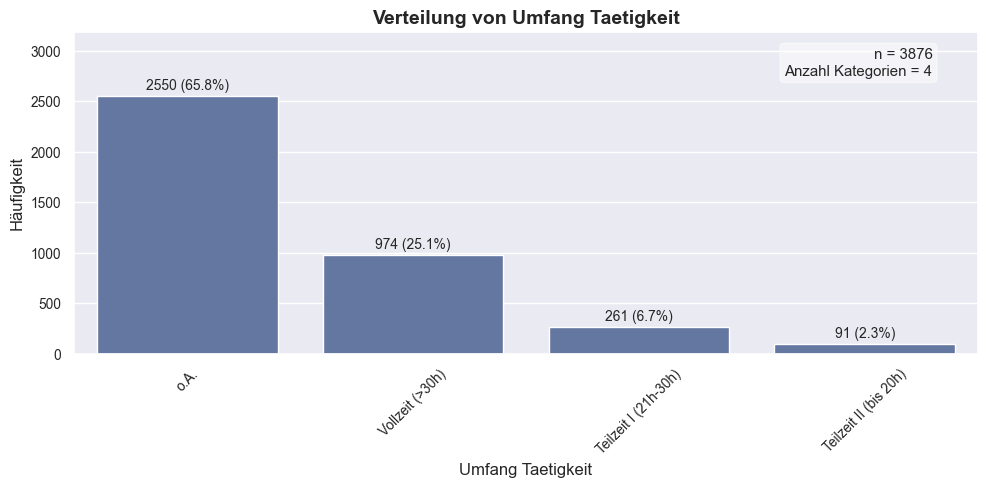

HTML in 'CEDUR_MIQ.html' written.


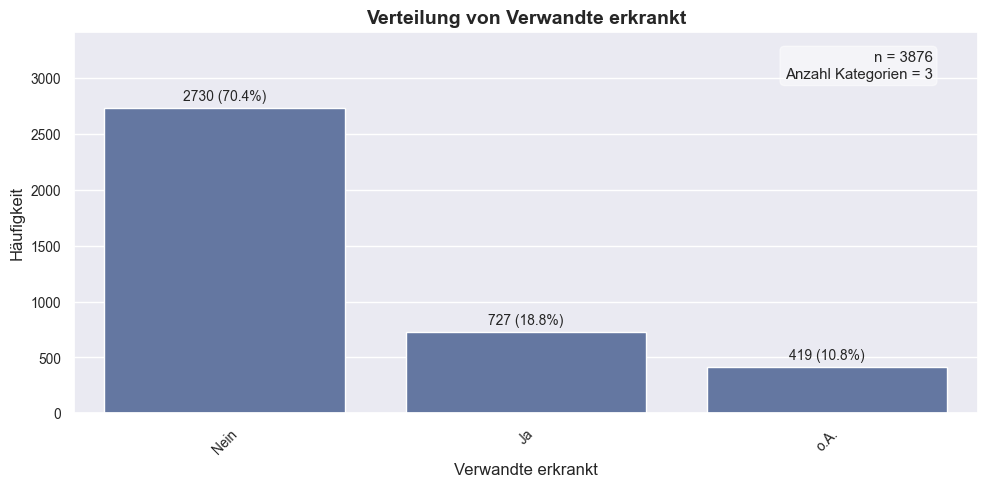

HTML in 'CEDUR_MIQ.html' written.


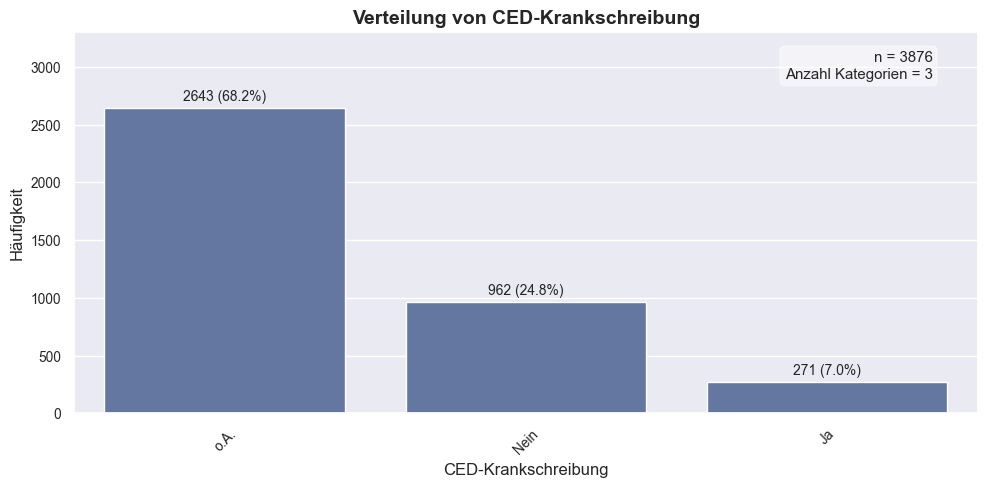

HTML in 'CEDUR_MIQ.html' written.


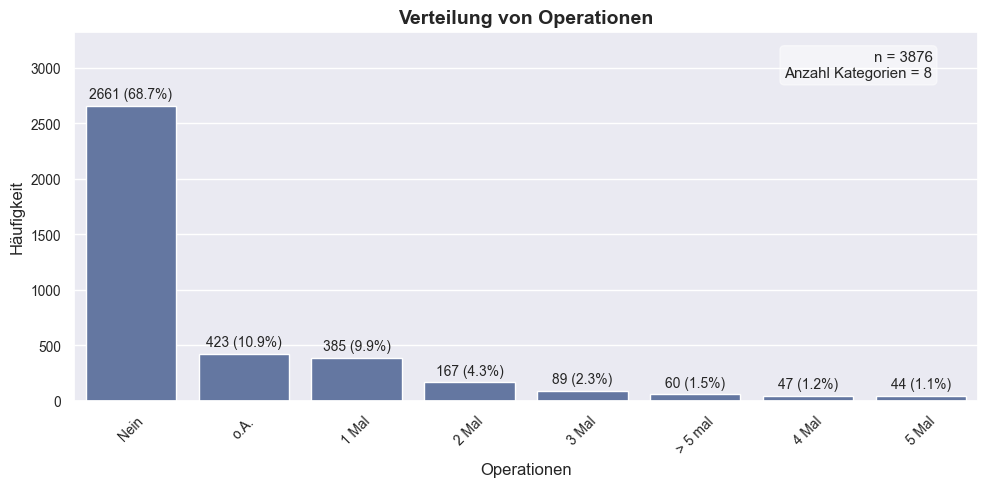

HTML in 'CEDUR_MIQ.html' written.
HTML in 'CEDUR_MIQ.html' written.


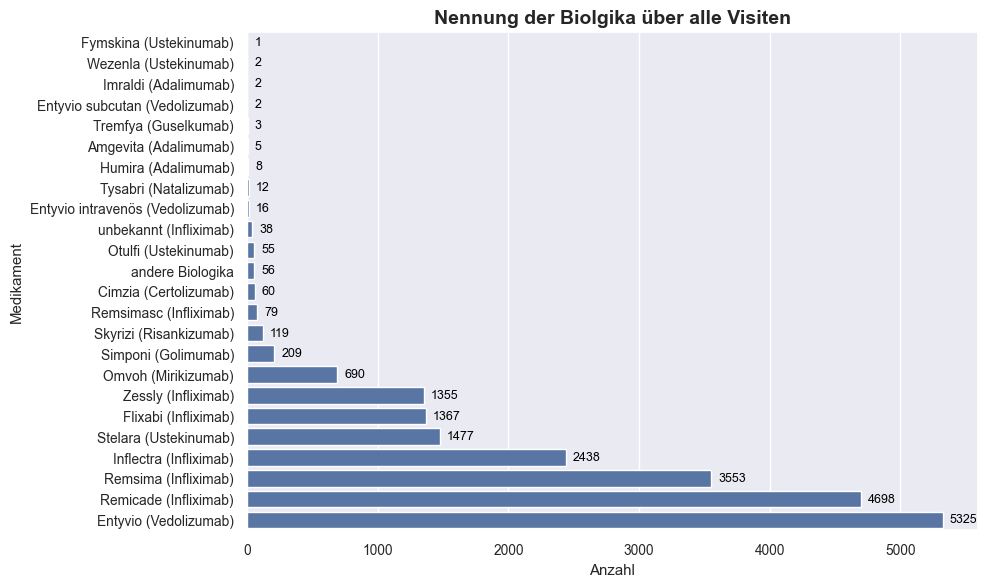

HTML in 'CEDUR_MIQ.html' written.


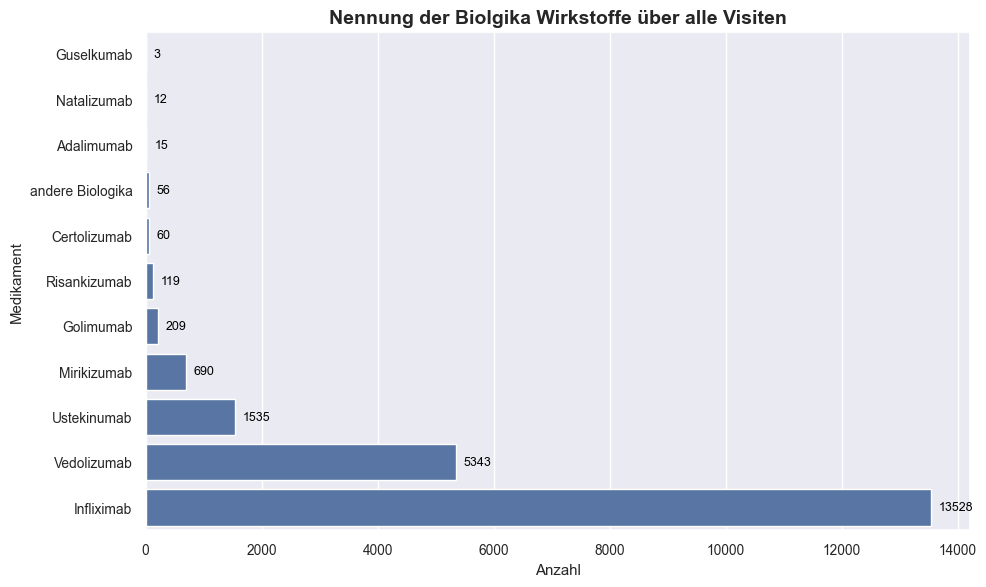

HTML in 'CEDUR_MIQ.html' written.


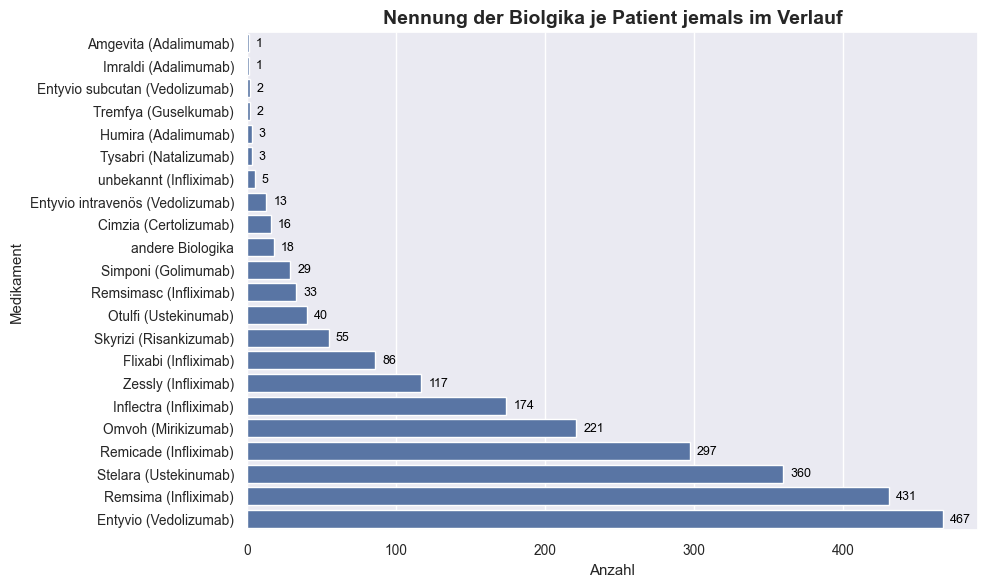

HTML in 'CEDUR_MIQ.html' written.


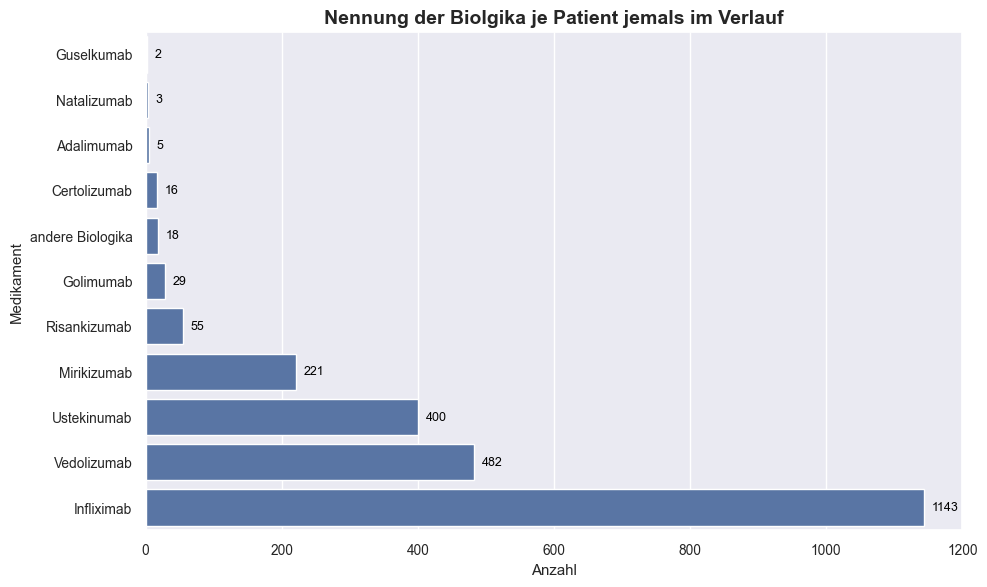

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="white") # , palette="pastel"
sns.set_theme(font_scale=0.9) 

#sns.color_palette("hls", 12)
# sns.set_palette("hls")
# sns.set_palette("tab20c")
# sns.set_palette("Spectral")
# sns.set_palette("coolwarm")
# Stil global setzen

def gen_randon_string(length=12):
  chars = string.ascii_letters + string.digits  # A-Z, a-z, 0-9
  return ''.join(random.choices(chars, k=length))

def img_to_base64_string(plt):
    buffer = io.BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0) 
    image_png = buffer.getvalue()
    base64_string = base64.b64encode(image_png).decode('utf-8')
    buffer.close()
    return base64_string

def bar_ext_all(col):
    if col in df_p.columns:
        # Daten vorbereiten
        series = df_p[col].dropna().astype(float)
        count = series.count()
        mean = series.mean()
        std = series.std()
        min_val = series.min()
        max_val = series.max()
        median = series.median()

        plt.figure(figsize=(10, 4))
        # Histogramm mit KDE (glatte Dichtekurve)
        sns.histplot(series, bins=20, kde=True)

        # Mittelwert-Linie
        plt.axvline(mean, color="blue", linestyle="--", linewidth=2, label=f"Mittelwert: {mean:.2f}")

        # Fehlerbereich (Mittelwert ± 1 Std-Abw.)
        plt.axvspan(mean - std, mean + std, alpha=0.2, label=f"±1 Std: {std:.2f}")

        # Statistik-Textbox
        stats_text = f"n = {count}\nmin = {min_val}\nmax = {max_val}\nmedian = {median}"
        plt.gca().text(0.95, 0.95, stats_text, 
                       horizontalalignment='right', verticalalignment='top', 
                       transform=plt.gca().transAxes,
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.5))

        # Achsen & Titel
        plt.xlabel(col, fontsize=12)
        plt.ylabel("Häufigkeit", fontsize=12)
        plt.title(f"Verteilung {col}", fontsize=14, weight="bold")
        plt.legend()
        plt.tight_layout()
        img_str = f'<img src="data:image/png;base64,{img_to_base64_string(plt)}">'
        # html_id = gen_randon_string()
        dis_html_str = "<table><tr style='text-align: right;'><td>" + img_str + "</td></tr></table>"
        write_html_file(dis_html_str, filename)
        plt.show()

def bar_ext_all_cat(col):
    if col in df_p.columns:
        series = df_p[col].dropna().astype(str)
        series = df_p[col].replace('', np.nan).fillna('o.A.').astype(str)
        counts = series.value_counts()
        percents = series.value_counts(normalize=True) * 100
        n = series.count()
        n_categories = len(counts)

        if n_categories <= 2:
            plt.figure(figsize=(6, 4))
            # Kreisdiagramm für ≤ 2 Kategorien
            manuelle_farben = ["#ca885b","#5a73ab"]
            plt.pie(counts, labels=counts.index, autopct="%1.1f%%", startangle=90,
                    colors=manuelle_farben) # sns.color_palette("pastel", n_categories)
            
            # Statistik-Textbox
            stats_text = f"n = {n}\nAnzahl Kategorien = {n_categories}"
            plt.gca().text(0.95, 0.95, stats_text,
                           horizontalalignment='right', verticalalignment='top',
                           transform=plt.gca().transAxes,
                           bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.5))
            
            plt.title(f"Verteilung {col}", fontsize=14, weight="bold")
            plt.tight_layout()
            plt.show()
        else:
            plt.figure(figsize=(10, 5)) # n_categories*1.2
            # Original Barplot
            sns.barplot(x=counts.index, y=counts.values, color="#5a73ab")
            
            # Obere Grenze für Platz über Balken
            plt.ylim(0, counts.values.max() * 1.25)

            # Werte über den Balken anzeigen
            for i, val in enumerate(counts.values):
                plt.text(i, val + n*0.01, f"{val} ({percents.iloc[i]:.1f}%)", ha='center', va='bottom', fontsize=10)

            # Statistik-Textbox
            stats_text = f"n = {n}\nAnzahl Kategorien = {n_categories}"
            plt.gca().text(0.95, 0.95, stats_text,
                           horizontalalignment='right', verticalalignment='top',
                           transform=plt.gca().transAxes,
                           bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.5))

            # Achsen & Titel
            plt.xlabel(col, fontsize=12)
            plt.ylabel("Häufigkeit", fontsize=12)
            plt.title(f"Verteilung von {col}", fontsize=14, weight="bold")
            plt.xticks(rotation=45)
            plt.tight_layout()
            img_str = f'<img src="data:image/png;base64,{img_to_base64_string(plt)}">'
            # html_id = gen_randon_string()
            dis_html_str = "<table><tr style='text-align: right;'><td>" + img_str + "</td></tr></table>"
            write_html_file(dis_html_str, filename)
            plt.show()

def plot_med_counts(counts, title):
    """
    counts: Pandas Series, z.B. df[mask]['Medikament Bezeichnung'].value_counts()
    """
    # Sortierung nach Häufigkeit
    counts = counts.sort_values(ascending=True)

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        x=counts.values,
        y=counts.index
    )

    # Absolutwerte an die Balken schreiben
    for i, (val, label) in enumerate(zip(counts.values, counts.index)):
        ax.text(val + max(counts.values) * 0.01, i, str(val),
                va="center", ha="left", fontsize=9, color="black")

    # Titel & Achsen
    plt.title(title, fontsize=14, weight="bold")
    plt.xlabel("Anzahl")
    plt.ylabel("Medikament")
    plt.tight_layout()
    img_str = f'<img src="data:image/png;base64,{img_to_base64_string(plt)}">'
    # html_id = gen_randon_string()
    dis_html_str = "<table><tr style='text-align: right;'><td>" + img_str + "</td></tr></table>"
    write_html_file(dis_html_str, filename)
    plt.show()

def age_pyramid(weiblich, maennlich):
    # gleiche Altersklassen sicherstellen
    altersklassen = weiblich.index.tolist()

    # Summen & Prozentwerte berechnen
    total_w = weiblich.sum()
    total_m = maennlich.sum()
    total = total_w + total_m

    perc_w = weiblich / total * 100
    perc_m = maennlich / total * 100

    # Plot
    plt.figure(figsize=(10,7))
    bars_m = plt.barh(altersklassen, -maennlich.values,label="Männlich", color="#5a73ab") 
    bars_w = plt.barh(altersklassen, weiblich.values, label="Weiblich", color="#ca885b") 

    # Zahlen & Prozente an die Balken schreiben
    for i, (val, perc) in enumerate(zip(maennlich.values, perc_m.values)):
        plt.text(-val - 10, i, f"{val} ({perc:.1f}%)", va="center", ha="right", color="black")

    for i, (val, perc) in enumerate(zip(weiblich.values, perc_w.values)):
        plt.text(val + 10, i, f"{val} ({perc:.1f}%)", va="center", ha="left", color="black")

    # Statistik-Box
    stats_text = (
        f"Gesamt: {total}\n"
        f"Weiblich: {total_w} ({total_w/total*100:.1f}%)\n"
        f"Männlich: {total_m} ({total_m/total*100:.1f}%)"
    )
    plt.gca().text(0.95, 0.05, stats_text,
                horizontalalignment='right', verticalalignment='bottom',
                transform=plt.gca().transAxes,
                bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.7))

    # Achsen schöner formatieren
    plt.xlabel("Anzahl")
    plt.ylabel("Altersklasse")
    plt.title("Alterspyramide bei Diagnose", fontsize=14, weight="bold")

    # X-Achse: positive Werte anzeigen
    xticks = plt.xticks()[0]
    plt.xticks(xticks, [abs(int(x)) for x in xticks])

    plt.legend(loc="upper center", ncol=2)
    plt.tight_layout()
    img_str = f'<img src="data:image/png;base64,{img_to_base64_string(plt)}">'
    # html_id = gen_randon_string()
    dis_html_str = "<table><tr style='text-align: right;'><td>" + img_str + "</td></tr></table>"
    write_html_file(dis_html_str, filename)
    plt.show()







# Angestellt tätig
# Selbständig tätig
# Student / Schüler / in Ausbildung
# Elternzeit|Arbeitssuchend / Arbeitslos
# Nicht berufstätig|Rentner (aufgrund CED)
# Rentner (aufgrund anderer Erkrankungen)
# Rentner (reguläre Altersrente);required

# Montreal CU

# Schulabschluss
# Taetigkeit

dis_html_str = "<h1>Allgemein</h1>"
write_html_file(dis_html_str, filename)
bar_ext_all_cat('Geschlecht')
bar_ext_all('Geburtsjahr')
bar_ext_all('Groesse')
bar_ext_all('Gewicht bei Einschluss')
bar_ext_all('Gewicht zuletzt')
bar_ext_all_cat('Rauchen bei Einschluss')
bar_ext_all_cat('Rauchen zuletzt')

dis_html_str = "<h1>Diagnose</h1>"
write_html_file(dis_html_str, filename)
bar_ext_all('Erstdiagnose')
bar_ext_all('Erstsymptomatik')
bar_ext_all('Altersprofil')
age_pyramid(weiblich, maennlich)
bar_ext_all('Zeit bis Diagnose')
bar_ext_all('Alter bei Diagnose')
bar_ext_all_cat('Diagnose')
bar_ext_all_cat('Montreal CU')
bar_ext_all_cat('Montreal MC')

dis_html_str = "<h1>Sonstiges</h1>"
write_html_file(dis_html_str, filename)
bar_ext_all_cat('Taetigkeit')
bar_ext_all_cat('Umfang Taetigkeit')
bar_ext_all_cat('Verwandte erkrankt')
bar_ext_all_cat('CED-Krankschreibung')
bar_ext_all('Krankenhaustage > 0 und < 360')
bar_ext_all_cat('Operationen')

dis_html_str = "<h1>Medikation (Biologika)</h1>"
write_html_file(dis_html_str, filename)
plot_med_counts(s_grouped_med, "Nennung der Biolgika über alle Visiten")
plot_med_counts(s_grouped_biosimilar, "Nennung der Biolgika Wirkstoffe über alle Visiten")
plot_med_counts(s_grouped_med_pat, "Nennung der Biolgika je Patient jemals im Verlauf")
plot_med_counts(s_grouped_biosimilar_pat, "Nennung der Biolgika je Patient jemals im Verlauf")


In [ ]:

# print(df_p.tail(5))

# print(df['Geschlecht'].value_counts())
# print(df['Diagnose'].value_counts())
# print(df.loc[2013061909133200, "Geburtsjahr"])
# print(df.columns.tolist())
# print(get_missing_value_fcids(df, df_temp["Groesse"].isna() | (df_temp["Groesse"] == "")))



In [ ]:



# print(df['Geschlecht'].value_counts())
# print(df['Diagnose'].value_counts())
# print(df.loc[2013061909133200, "Geburtsjahr"])
# print(df.columns.tolist())
# print(get_missing_value_fcids(df, df_temp["Groesse"].isna() | (df_temp["Groesse"] == "")))



In [ ]:


def g_bar(col_1, col_2, mask):
    cross_tab = pd.crosstab(df_p[mask][col_1], df_p[mask][col_2])

    print("Ihre dynamisch erstellte Kreuztabelle:")
    print(cross_tab)
    print("\n")

   

    # Umwandlung des DataFrames in das Long-Format
    df_long = cross_tab.reset_index().melt(
        id_vars=[col_1],
        var_name=col_2,
        value_name='Anzahl'
    )

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=col_2,
        y='Anzahl',
        hue=col_1 ,
        data=df_long
    )

    plt.title("Häufigkeit der " + col_2  + " nach " + col_1)
    plt.xlabel(col_2)
    plt.ylabel("Anzahl der Fälle")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


g_bar('Geschlecht', 'Diagnose', (df_p['Diagnose'] != ''))



Ihre dynamisch erstellte Kreuztabelle:
Diagnose    Colitis indeterminata  Colitis ulcerosa  Morbus Crohn
Geschlecht                                                       
männlich                       20               900           892
weiblich                       28               921          1090




NameError: name 'plt' is not defined

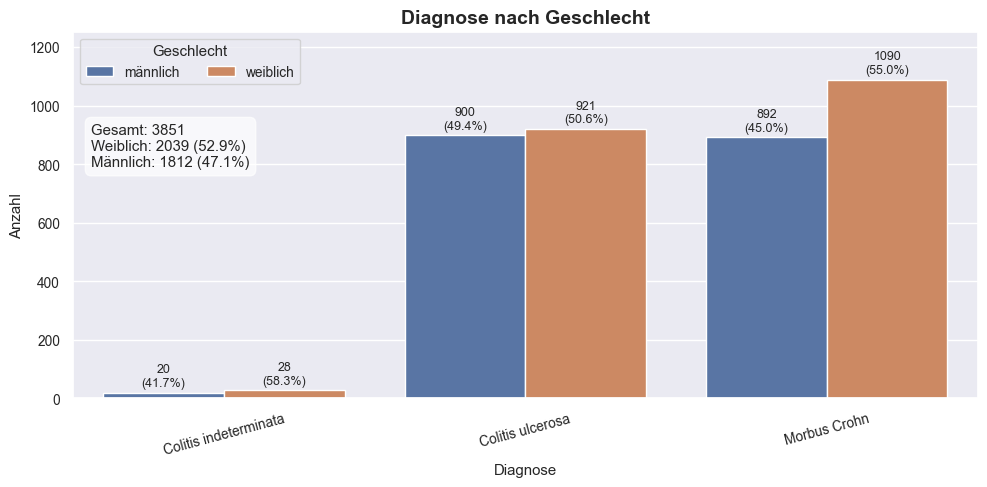

In [ ]:
mask = df_p['Diagnose'] != ''

# Crosstab ohne Summen
col_1 = 'Geschlecht'
col_2 = 'Diagnose'

cross_tab = pd.crosstab(df_p[mask][col_1], df_p[mask][col_2])


# cross_tab bereits erzeugt:
# cross_tab = pd.crosstab(df_p['Geschlecht'], df_p['Diagnose'])
df_plot = cross_tab.copy()

# Falls 'All' vorhanden: entfernen
if "All" in df_plot.index:
    df_plot = df_plot.drop(index="All")
if "All" in df_plot.columns:
    df_plot = df_plot.drop(columns="All")

# Definierte Reihenfolge der Diagnosen und Geschlechter (so wie in df_plot)
diagnoses = df_plot.columns.tolist()
hue_order = df_plot.index.tolist()   # z.B. ['männlich','weiblich']

# Long-Format (nur zum Plotten mit seaborn)
df_melt = df_plot.reset_index().melt(id_vars=col_1, var_name=col_2, value_name="Anzahl")

# Plot erzeugen (fixe Reihenfolge via order/hue_order)
plt.figure(figsize=(10,5))
ax = sns.barplot(
    data=df_melt,
    x=col_2,
    y="Anzahl",
    hue=col_1,
    order=diagnoses,
    hue_order=hue_order
)

# Offset für Beschriftungen (dynamisch)
offset = df_plot.values.max() * 0.01

# Annotation: pro Container (Container = ein Geschlecht), in X-Reihenfolge
for j, container in enumerate(ax.containers):
    gender = hue_order[j]
    for i, bar in enumerate(container):
        diagnosis = diagnoses[i]
        val = int(df_plot.loc[gender, diagnosis])
        # Prozent bezogen auf Summe dieser Diagnose (männlich+weiblich)
        total_for_diag = df_plot[diagnosis].sum()
        pct = (val / total_for_diag * 100) if total_for_diag > 0 else 0.0

        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()
        ax.text(x, y + offset, f"{val}\n({pct:.1f}%)", ha="center", va="bottom", fontsize=9)

# Statistikbox mit Summen
gesamt = int(df_plot.values.sum())
gesamt_w = int(df_plot.loc["weiblich"].sum()) if "weiblich" in df_plot.index else 0
gesamt_m = int(df_plot.loc["männlich"].sum()) if "männlich" in df_plot.index else 0
stat_text = (
    f"Gesamt: {gesamt}\n"
    f"Weiblich: {gesamt_w} ({(gesamt_w/gesamt*100):.1f}%)\n"
    f"Männlich: {gesamt_m} ({(gesamt_m/gesamt*100):.1f}%)"
)
ax.text(0.02, 0.75, stat_text,
        transform=ax.transAxes,
        ha="left", va="top",
        bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.7))

# Achsen & 
plt.ylim(0, df_plot.values.max() * 1.15)
plt.title(col_2 + " nach " + col_1, fontsize=14, weight="bold")
plt.xlabel(col_2)
plt.ylabel("Anzahl")

plt.legend(title=col_1, loc="upper left", ncol=len(hue_order))
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [ ]:

# Verbindung schließen (wichtiger Schritt)
# cursor.close()
# mysql_conn.close()

In [ ]:

# query = "SELECT DISTINCT fcid FROM `forms_10010` WHERE " + usergroup_str
# df = pd.read_sql(query, engine)
# print(df.shape[0])

# query = "SELECT fcid,fcont as diagnosis FROM `forms_10010` WHERE fid=95 AND " + usergroup_str
# df_temp = pd.read_sql(query, engine)

# query = "SELECT fcid,fcont as diagnosis FROM `forms_10010` WHERE fid=95 AND " + usergroup_str
# df_temp = pd.read_sql(query, engine)

# df = pd.merge(df, df_temp, on='fcid')


# DUPLIKTE FINDEN
# unique_dates_per_pid = df.groupby('pid')['Datum der Erstdiagnose'].transform('nunique')
# df_prove = df[unique_dates_per_pid > 1]

# pids_with_different_values = df_prove['pid'].unique().tolist()
# print(len(pids_with_different_values))
# # df_prove

# for pid in pids_with_different_values:
#     print(df_prove[df_prove['pid']==pid])